In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
from sklearn.datasets import load_boston

In [2]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = pd.DataFrame(boston.target, columns=['PRICE'])

## 다중 선형회귀

In [3]:
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


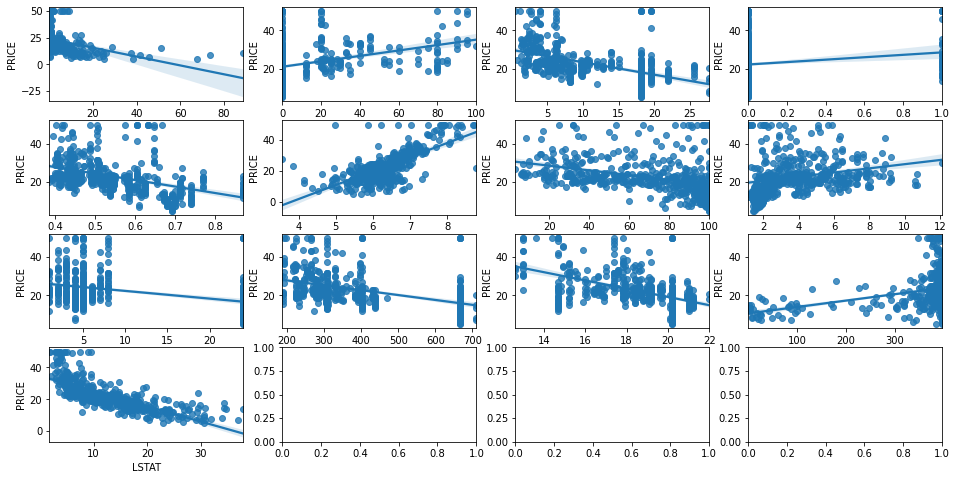

In [4]:
# 여러개의 그래프를 하나의 plot에 담기 위한 방법
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=4)

# 순서와 해당 값을 전달하는 enumerate 0~
for i, feature in enumerate(X.columns):
  row = int(i/4)
  col = i%4
  sns.regplot(x=feature, y=Y['PRICE'], data=X, ax=axs[row][col])

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_lr_eval(y_test, pred):
  log_y = np.log1p(y_test)
  log_pred = np.log1p(pred)
  rmsle = np.sqrt(np.mean((log_y - log_pred)**2))

  rmse = np.sqrt(mean_squared_error(y_test, pred))

  mae = mean_absolute_error(y_test, pred)
  print('RMSLE : {0:.4f}, RMSE : {1:.4f}, MAE : {2:.4f}'.format(rmsle, rmse, mae))

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state = 156)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# sklearn에는 RMSE가 따로 없어서 np.sqrt를 이용해 루트를 씌워서 출력한다
print("MSE : {0:.4f}, RMSE : {1:.4f}".format(mean_squared_error(y_test, pred), np.sqrt(mean_squared_error(y_test, pred))))
print("R2 : {0:.4f}".format(r2_score(y_test,pred)))
print("절편값 : ", lr.intercept_)
print('회귀 계수값 : ', np.round(lr.coef_, 1))

MSE : 17.2969, RMSE : 4.1590
R2 : 0.7572
절편값 :  [40.99559517]
회귀 계수값 :  [[ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
   -0.6]]


In [8]:
# lr.coef_의 값이 array형태이므로 list형식으로 변환해서 인덱스와 숫자 맞춤
coeff = pd.Series(data=list(np.round(lr.coef_,1)[0]), index=X.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [9]:
from sklearn.model_selection import cross_val_score

X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = pd.DataFrame(boston.target, columns=['PRICE'])
lr = LinearRegression()

# cross_val_score 의 scoring은 큰 수를 더 좋은 결과로 받아들이기 때문에 음수로 표현된다. 실제로는 작아야 좋은 결과이므로. 
neg_mse_scores = cross_val_score(lr, X, Y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5-fold MSE : ", np.round(-1 * neg_mse_scores, 2))
print("5-fold RMSE : ", np.round(rmse_scores, 2))
print("5-fold average RMSE :", np.round(avg_rmse,2))

5-fold MSE :  [12.46 26.05 33.07 80.76 33.31]
5-fold RMSE :  [3.53 5.1  5.75 8.99 5.77]
5-fold average RMSE : 5.83


## 규제 선형모델 - 릿지, 라쏘, 엘라스틱넷

과적합을 방지하기 위해 규제를 통해 모델의 회귀계수 값이 커지지 않게 alpha값을 조정하며 최적모델을 위한 Cost함수 구현

*   릿지 - L2규제, 제곱에 대한 페널티 적용
*   라쏘 - L1규제, 절대값에 대한 페널치 적용, 영향력이 크지 않은 값을 0으로 반환하기 때문에 피처가 줄어들 수 있다.
*   엘라스틱넷 - 회귀계수의 변화가 큰것에 대비해 라쏘회귀에 L2규제 추가



In [10]:
# 릿지

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X, Y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5-fold MSE : ", np.round(-1 * neg_mse_scores, 2))
print("5-fold RMSE : ", np.round(rmse_scores, 2))
print("5-fold average RMSE :", np.round(avg_rmse,2))

5-fold MSE :  [11.42 24.29 28.14 74.6  28.52]
5-fold RMSE :  [3.38 4.93 5.31 8.64 5.34]
5-fold average RMSE : 5.52


In [11]:
# 릿지 alpha값을 조정하며 최적모델 찾기

alphas = np.arange(10,101,10)
best_alpha = []
for alpha in alphas :
  ridge = Ridge(alpha=alpha)
  neg_mse_scores = cross_val_score(ridge, X, Y, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  best_alpha.append([avg_rmse, alpha])


print('alpha : {1}, avg_rmse : {0:.4f}'.format(sorted(best_alpha)[0][0],sorted(best_alpha)[0][1]))


alpha : 100, avg_rmse : 5.3296


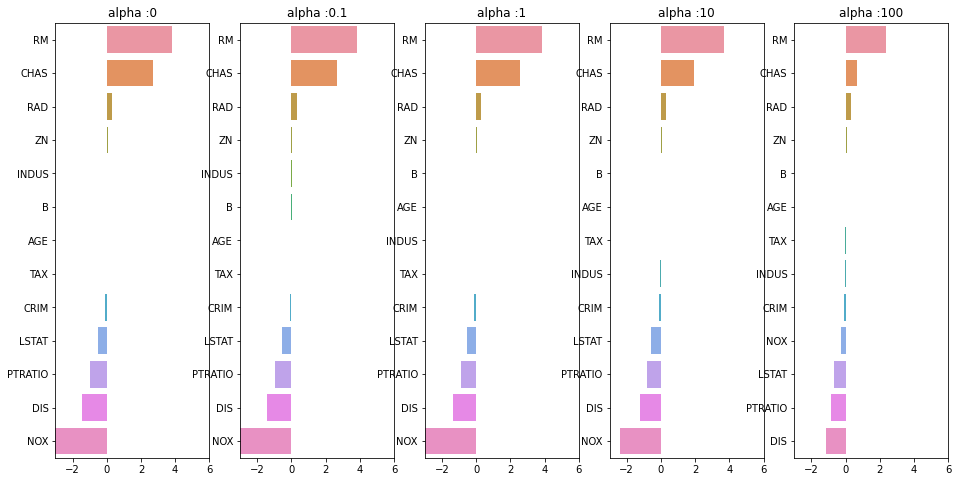

,alpha :0,alpha :0.1,alpha :1,alpha :10,alpha :100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


In [12]:
#alpha 값에 따른 릿지 회귀계수 값

alphas = [0, 0.1, 1, 10, 100]

fig, axs = plt.subplots(figsize=(16,8), ncols=5, nrows=1)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha=alpha)
  ridge.fit(X, Y)
  coeff = pd.Series(data = list(ridge.coef_[0]), index=X.columns)
  colname='alpha :'+str(alpha)
  coeff_df[colname]=coeff
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3,6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()
coeff_df.sort_values(by='alpha :0', ascending=False)

In [13]:
# 라쏘회귀 & 엘라스틱넷
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data=None, y_data=None, verbose=True):
  coeff_df = pd.DataFrame()
  if verbose : print('########'+ model_name,'########')

  for param in params : 
    if model_name == "Ridge":
      model = Ridge(alpha=param)
    elif model_name == "Lasso" :
      model = Lasso(alpha=param)
    elif model_name == "ElasticNet" :
      model = ElasticNet(alpha=param, l1_ratio=0.7)
    
    neg_mse_scores = cross_val_score(model, X_data, y_data, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    # cv는 evaluation metric 만 반환하므로 회귀 계수를 위해 모델 fit()
    model.fit(X_data, y_data)

    print('alpha 가 {0} 일때 5 폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
    coeff = pd.Series(data = model.coef_[0], index=X_data.columns)
    colname='alpha :'+str(param)
    coeff_df[colname]=coeff
    coeff = coeff.sort_values(ascending=False)
  return coeff_df

In [14]:
# 라쏘
lasso_alpha=[0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params=lasso_alpha, X_data=X, y_data=Y)
coeff_lasso_df.sort_values(by='alpha :0.07', ascending=False)

########Lasso ########
alpha 가 0.07 일때 5 폴드 세트의 평균 RMSE : 5.612
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 5.615
alpha 가 0.5 일때 5 폴드 세트의 평균 RMSE : 5.669
alpha 가 1 일때 5 폴드 세트의 평균 RMSE : 5.776
alpha 가 3 일때 5 폴드 세트의 평균 RMSE : 6.189


,alpha :0.07,alpha :0.1,alpha :0.5,alpha :1,alpha :3
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
ZN,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
INDUS,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
CHAS,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
NOX,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
RM,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
AGE,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
DIS,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
RAD,-0.098193,-0.097894,-0.083289,-0.063437,-0.0
TAX,-0.098193,-0.097894,-0.083289,-0.063437,-0.0


In [15]:
# 엘라스틱넷
ElasticNet_alpha=[0.07,0.1,0.5,1,3]
coeff_ElasticNet_df = get_linear_reg_eval('ElasticNet',params=lasso_alpha, X_data=X, y_data=Y)
coeff_ElasticNet_df.sort_values(by='alpha :0.07', ascending=False)

########ElasticNet ########
alpha 가 0.07 일때 5 폴드 세트의 평균 RMSE : 5.542
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 5.526
alpha 가 0.5 일때 5 폴드 세트의 평균 RMSE : 5.467
alpha 가 1 일때 5 폴드 세트의 평균 RMSE : 5.597
alpha 가 3 일때 5 폴드 세트의 평균 RMSE : 6.068


,alpha :0.07,alpha :0.1,alpha :0.5,alpha :1,alpha :3
CRIM,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
ZN,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
INDUS,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
CHAS,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
NOX,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
RM,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
AGE,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
DIS,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
RAD,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058
TAX,-0.099468,-0.099213,-0.08907,-0.073577,-0.019058


## 선형회귀모델을 위한 데이터 변환

**중요피처들이나 타겟변수가 분포가 왜곡됐을경우 사용한다. 타겟변수는 일반적으로 로그변환을 한다.**

*   정규화 (StandardScaler, MinMaxScaler)
*   다항특성적용(정규화 해서 성능에 향상이 없는경우, 피처가 많아지기 때문에 잘 안씀)
*   로그변환(np.log1p)



In [16]:
# 데이터 변환을 위한 함수작성

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
def get_scaled_data(method = 'None', p_degree='None', data='None'):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(data)
  elif method == 'Log':
    scaled_data = np.log1p(data)
  else :
    scaled_data = data
  
  if p_degree != 'None':
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(data)
  
  return scaled_data

In [17]:
alphas = [0.1, 1, 10, 100]

# 데이터 변환의 모든 경우의 수 모델 성능 확인, 
scale_method = [('None','None'),('Standard','None'), ('Standard',2), ('MinMax','None'), ('MinMax',2), ("Log",'None')]

for method in scale_method :
  # get_scaled_data의 리턴값이 ndarray이므로 데이터프레임형태로 변환
  scaled_data = pd.DataFrame(get_scaled_data(method=method[0], p_degree=method[1], data=X))

  print('\n## 변환유형 : {0}, Polynomial degree : {1}'.format(method[0],method[1]))

  get_linear_reg_eval("Ridge", params=alphas, X_data = scaled_data, y_data= Y)



## 변환유형 : None, Polynomial degree : None
########Ridge ########
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 5.788
alpha 가 1 일때 5 폴드 세트의 평균 RMSE : 5.653
alpha 가 10 일때 5 폴드 세트의 평균 RMSE : 5.518
alpha 가 100 일때 5 폴드 세트의 평균 RMSE : 5.330

## 변환유형 : Standard, Polynomial degree : None
########Ridge ########
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 5.826
alpha 가 1 일때 5 폴드 세트의 평균 RMSE : 5.803
alpha 가 10 일때 5 폴드 세트의 평균 RMSE : 5.637
alpha 가 100 일때 5 폴드 세트의 평균 RMSE : 5.421

## 변환유형 : Standard, Polynomial degree : 2
########Ridge ########
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 9.141
alpha 가 1 일때 5 폴드 세트의 평균 RMSE : 8.938
alpha 가 10 일때 5 폴드 세트의 평균 RMSE : 10.556
alpha 가 100 일때 5 폴드 세트의 평균 RMSE : 10.566

## 변환유형 : MinMax, Polynomial degree : None
########Ridge ########
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 5.764
alpha 가 1 일때 5 폴드 세트의 평균 RMSE : 5.465
alpha 가 10 일때 5 폴드 세트의 평균 RMSE : 5.754
alpha 가 100 일때 5 폴드 세트의 평균 RMSE : 7.635

## 변환유형 : MinMax, Polynomial degree : 2
########Ridge ########
alpha 가 0.1 일때 5 폴드 세트의 평균 RMSE : 9.141

## 로지스틱 회귀

- 보통은 이진분류에 사용한다. 
- 함수의 반환값을 확률로 간주해 확률에 따라 분류를 결정
- 임계값 조정으로 불균형 데이터 문제 해결할 수 있다.

**주요 하이퍼 파라미터**
- penalty = 'l2', 'l1' 기본값은 'l2'
- C = 1 / alpha, C값이 작을수록 규제 강도가 큼

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score

In [19]:
cancer = load_breast_cancer()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, cancer.target, test_size=0.3, random_state=0)

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print('Accuracy = {0:.3f}'.format(accuracy_score(y_test, pred)))
print('ROC - AUC = {0:.3f}'.format(roc_auc_score(y_test, pred)))

Accuracy = 0.977
ROC - AUC = 0.972


In [20]:
params = {'penalty':['l2'],
          'C' : [0.01, 0.1, 1, 5, 10]}

grid_cf = GridSearchCV(lr, param_grid=params, scoring='accuracy',cv=3)
grid_cf.fit(X_train, y_train)
print("최적의 하이퍼파라미터 : {0},  최적 평균 정확도 : {1:.3f}".format(grid_cf.best_params_, grid_cf.best_score_))

최적의 하이퍼파라미터 : {'C': 1, 'penalty': 'l2'},  최적 평균 정확도 : 0.982


## 회귀트리

- 리프노드에 속한 데이터 값의 평균을 구해 회귀 예측값을 계산
- 회귀계수를 제공하는 coef_ 속성이 없음. 대신 feature_importances를 이용해 피처별 중요도를 알 수 있다.
- 선형회귀는 직선으로 예측회귀선을 표현하는데 반해 회귀트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단형태로 회귀선을 만든다.

**주요 하이퍼 파라미터**
- max_depth, n_estormators 등등, 분류에서 쓰인 파라미터와 유사함

In [21]:
# 모델과 데이터 세트를 받아 교차검증으로 평균RMSE를 계산해주는 함수 구현

def get_model_cv_prediction(model, X_data, y_target) :
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print("##### ", model.__class__.__name__,' #####')
    print(' 5 cross validation AVG RMSE : {0:.4f}'.format(avg_rmse))

In [22]:
# 회귀트리모델을 만들어서 평균RMSE 비교 (하이퍼파라미터 조정필요)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)

boston_df['PRICE'] = boston.target

X_data = boston_df.drop('PRICE', axis=1)
y_target = boston_df['PRICE']

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

models = [dt_reg,gb_reg,rf_reg,xgb_reg,lgb_reg]

for model in models :
  get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 cross validation AVG RMSE : 5.9780
#####  GradientBoostingRegressor  #####
 5 cross validation AVG RMSE : 4.2692
#####  RandomForestRegressor  #####
 5 cross validation AVG RMSE : 4.4204
[10:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 cross validation AVG RMSE : 4.0889
#####  LGBMRegressor  #####
 5 cross validation AVG RMSE : 4.6464


[10:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


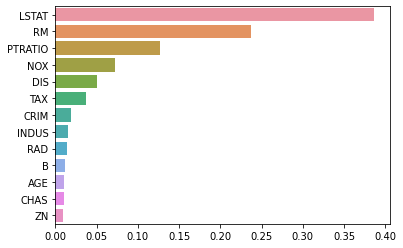

In [23]:
# feature importances 구하기

xgb_reg.fit(X_data, y_target)

feature_importances = pd.Series(xgb_reg.feature_importances_, index=X_data.columns)
feature_importances = feature_importances.sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index)

## 회귀 실습

1. 자전거 수요 예측 실습

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
from sklearn.datasets import load_boston

In [8]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
os.environ ['KAGGLE_USERNAME']='jihundong'
os.environ ['KAGGLE_KEY']='afcde26cfbe0329940574910ea325ac3'

!rm *.*
!kaggle competitions download -c bike-sharing-demand
#!unzip '*.zip'

df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 42.1MB/s]
  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 88.3MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 114MB/s]


In [9]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [11]:
# datatime을 년,월,일,시 로 변경
df['datetime'] = df.datetime.apply(pd.to_datetime)

df['year'] = df['datetime'].apply(lambda x:x.year)
df['month'] = df['datetime'].apply(lambda x:x.month)
df['day'] = df['datetime'].apply(lambda x:x.day)
df['hour'] = df['datetime'].apply(lambda x:x.hour)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [13]:
# 필요없는 변수 삭제 , casual+registered = count이므로 두 변수 삭제
df.drop(['datetime', 'casual','registered'], axis=1, inplace=True)

In [27]:
# 평가지표 함수 구현 RMSLE, RMSE, MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_regr(y_test, pred):
  log_y = np.log1p(y_test)
  log_pred = np.log1p(pred)
  rmsle = np.sqrt(np.mean((log_y - log_pred)**2))

  rmse = np.sqrt(mean_squared_error(y_test, pred))

  mae = mean_absolute_error(y_test, pred)

  print('RMSLE : {0:.3f},  RMSE : {1:.3f},  MAE : {2:.3f}'.format(rmsle, rmse, mae))

In [17]:
# 타겟데이터의 분포확인 및 범주형 변수의 원핫 인코딩
from sklearn.model_selection import train_test_split

X_data = df.drop('count', axis=1)
y_target = df['count']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=0)

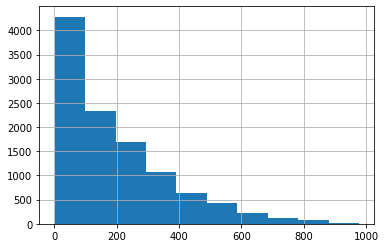

In [19]:
# 타겟데이터의 불균형 확인
y_target.hist()

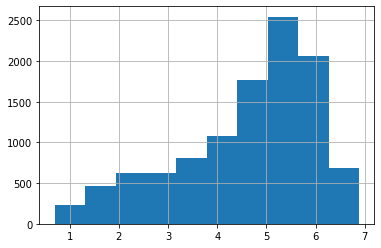

In [20]:
# 로그변환으로 불균형 해소 확인
y_target_log = np.log1p(y_target)
y_target_log.hist()

In [22]:
# season, weather, year, month, day, hour의 one-hot encoding 실시
X_ohe = pd.get_dummies(X_data, columns=['year','month','day','hour','season','weather','holiday','workingday'], drop_first=True)
X_ohe.head()

,temp,atemp,humidity,windspeed,year_2012,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,season_2,season_3,season_4,weather_2,weather_3,weather_4,holiday_1,workingday_1
0,9.84,14.395,81,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# 변환한 데이터로 다시 테스트/트레인 셋 나누기

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_target_log, test_size=0.3, random_state=0)

In [35]:
# 모델별로 학습 및 평가 진행

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)

# 로그변환을 했으니까 평가를 위해 다시 원래값으로 복원
  if is_expm1 :
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)

  print('### ',model.__class__.__name__,' ###')
  evaluate_regr(y_test, pred)


lr = LinearRegression()
ridge = Ridge(alpha=5)
lasso = Lasso(alpha=0.001)

for i in [lr,ridge,lasso]:
  get_model_predict(i,X_train, X_test, y_train, y_test, is_expm1=True)

###  LinearRegression  ###
RMSLE : 0.590,  RMSE : 97.687,  MAE : 63.382
###  Ridge  ###
RMSLE : 0.592,  RMSE : 98.417,  MAE : 63.866
###  Lasso  ###
RMSLE : 0.594,  RMSE : 99.052,  MAE : 64.024


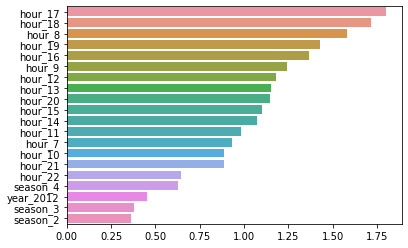

In [41]:
# 중요 변수 파악(상위 20개)
coef = pd.Series(lasso.coef_, index=X_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)


In [43]:
# 회귀트리로 예측

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf = RandomForestRegressor(n_estimators=1000)
gbm = GradientBoostingRegressor(n_estimators=1000)
xgb = XGBRegressor(n_estimators=1000)
lgb = LGBMRegressor(n_estimators=1000)

for i in [rf,gbm,xgb,lgb] :
  get_model_predict(i, X_train, X_test, y_train, y_test, is_expm1=True)

###  RandomForestRegressor  ###
RMSLE : 0.466,  RMSE : 68.644,  MAE : 42.806
###  GradientBoostingRegressor  ###
RMSLE : 0.363,  RMSE : 53.133,  MAE : 33.006
[14:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
###  XGBRegressor  ###
RMSLE : 0.361,  RMSE : 52.681,  MAE : 32.805
###  LGBMRegressor  ###
RMSLE : 0.327,  RMSE : 47.797,  MAE : 29.772


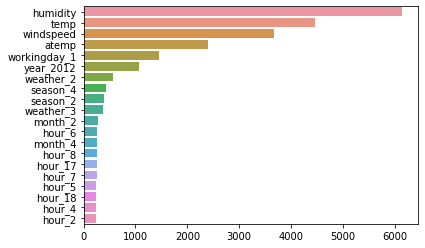

In [51]:
# 중요변수 파악

feature_series = pd.Series(data=lgb.feature_importances_, index=X_ohe.columns)
feature_series_sort = feature_series.sort_values(ascending=False)[:20]
sns.barplot(x=feature_series_sort.values, y=feature_series_sort.index)